In [76]:
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, \
    mean_absolute_percentage_error, mean_squared_error


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


import matplotlib.pyplot as plt
import seaborn as sns

---

In [30]:
# Инициализация датасета
df = pd.read_csv('./data/train.csv', parse_dates=['date'], index_col=['date'])

/var/folders/df/dz8wtw0j7791hg98mrx_thxc0000gn/T/ipykernel_28010/239384023.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/train.csv', parse_dates=['date'], index_col=['date'])


In [31]:
df.rename(columns={'unit_sales':'sales'}, inplace=True)
display(df.head()) # Основная структура таблицы
print(f"Количество строк исходного датасета: {df.shape[0]}")

,id,store_nbr,item_nbr,sales,onpromotion
date,,,,,
2013-01-01,0,25,103665,7.0,NaN
2013-01-01,1,25,105574,1.0,NaN
2013-01-01,2,25,105575,2.0,NaN
2013-01-01,3,25,108079,1.0,NaN
2013-01-01,4,25,108701,1.0,NaN


Количество строк исходного датасета: 125497040


---

### Предподготовка данных

In [32]:
# Отфильтруем по 25 магазину и найдем сумму продаж
df_25_raw = df.query("store_nbr == 25")
df_25 = df_25_raw.groupby(by=df_25_raw.index)["sales"].sum()

# Зададим частоту равную дню и проведема интерполяцию для последующей декомпозиции
df_25 = df_25.asfreq(freq="D")
df_25 = df_25.interpolate(method="linear")
df_25 = pd.DataFrame(df_25)

display(df_25.head())
print(f"Пропуски: {df_25.isna().sum()}")

,sales
date,
2013-01-01,2511.619
2013-01-02,5316.224
2013-01-03,4442.913
2013-01-04,4844.354
2013-01-05,5817.526


Пропуски: sales    0
dtype: int64


In [33]:
# Сохраним датасет для последующего быстрого открытия
df_25_raw.to_csv('./data/df_25_raw.csv')
df_25.to_csv("./data/df_25.csv")

In [34]:
# Откроем сохраненный датасет
df_25 = pd.read_csv("./data/df_25.csv", parse_dates=["date"], index_col=["date"])
df_25.head()

,sales
date,
2013-01-01,2511.619
2013-01-02,5316.224
2013-01-03,4442.913
2013-01-04,4844.354
2013-01-05,5817.526


---

### Сезонное разложение ряда

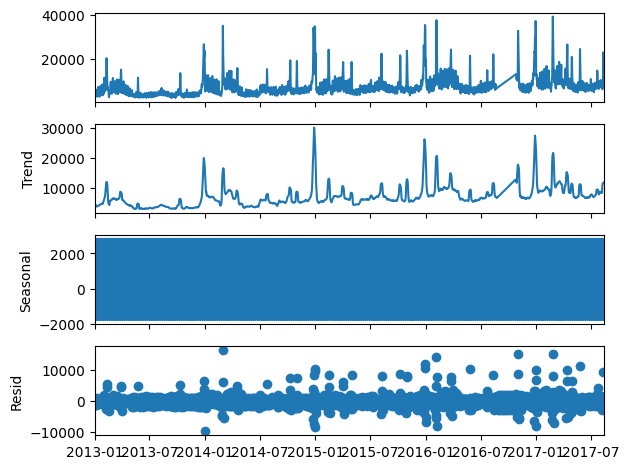

In [35]:
decomposition = seasonal_decompose(df_25)
decomposition.plot();

---

### Ответы на вопросы модуля 5

In [36]:
seasonal = decomposition.seasonal
trend = decomposition.trend

residuals = decomposition.resid
# residuals = residuals.dropna()

print(f"Количество элементов в исходном датасете: {df.shape[0]}")
print(f"Количество элементов в шумовой части: {residuals.shape[0]}")
print(f"Количество числовых элементов в шумовой части: {residuals.dropna().shape[0]}")
print(f"Количество элементов в сезонной части: {seasonal.shape[0]}")
print(f"Количество элементов в трендовой части: {trend.shape[0]}")

Количество элементов в исходном датасете: 125497040
Количество элементов в шумовой части: 1688
Количество числовых элементов в шумовой части: 1682
Количество элементов в сезонной части: 1688
Количество элементов в трендовой части: 1688


In [74]:
# Тест на стационарность
def adfuller_test(data, column='None'):
    test = adfuller(data[column])
    print("adf: ", test[0])
    print("p-value: ", test[1])
    print("Critical values: ", test[4])
    if (
        test[0] > test[4]["5%"]
    ):  # проверка, больше ли критического полученное значение для нашего ряда
        print("ряд не стационарен")
    else:
        print("ряд стационарен")

adfuller_test(df_25, 'sales')

adf:  -5.001296622947667
p-value:  2.206239337839221e-05
Critical values:  {'1%': -3.4342906911169404, '5%': -2.8632805908715726, '10%': -2.5676966486957706}
ряд стационарен


---

### Формирование тренировочной и тестовой выборок

In [38]:
tscv = TimeSeriesSplit(n_splits=3, test_size=7)

train_test_groups = tscv.split(df_25["sales"])


for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 1667 TEST size: 7
TRAIN size: 1674 TEST size: 7
TRAIN size: 1681 TEST size: 7


---

### Ответы на вопросы модуля 8

In [39]:
# Реинициализируем датафрейм
data = df_25.copy()

In [40]:
# Постройте скользящее среднее c окном 5.
data["rolling_mean"] = data.rolling(window=5, min_periods=1).mean()
data.head(15)

,sales,rolling_mean
date,,
2013-01-01,2511.619,2511.6190
2013-01-02,5316.224,3913.9215
2013-01-03,4442.913,4090.2520
2013-01-04,4844.354,4278.7775
2013-01-05,5817.526,4586.5272
2013-01-06,3201.695,4724.5424
2013-01-07,2783.978,4218.0932
2013-01-08,2884.284,3906.3674
2013-01-09,3565.639,3650.6244


In [41]:
# Постройте скользящее квадратическое отклонение c окном 5.
data["rolling_std"] = data["sales"].rolling(window=5, min_periods=1).std()
data.head(15)

,sales,rolling_mean,rolling_std
date,,,
2013-01-01,2511.619,2511.6190,NaN
2013-01-02,5316.224,3913.9215,1983.155214
2013-01-03,4442.913,4090.2520,1435.175821
2013-01-04,4844.354,4278.7775,1230.983569
2013-01-05,5817.526,4586.5272,1268.873437
2013-01-06,3201.695,4724.5424,994.665070
2013-01-07,2783.978,4218.0932,1233.965510
2013-01-08,2884.284,3906.3674,1354.005326
2013-01-09,3565.639,3650.6244,1249.257405


In [42]:
# Вычисление линий Боллинджера с окном в 30.
data.drop(["rolling_mean", "rolling_std"], axis=1, inplace=True)

# Окно скольжения
window = 30
data["rolling_mean"] = data["sales"].rolling(window=window, min_periods=1).mean()

data["rolling_std"] = data["sales"].rolling(window=window, min_periods=1).std()

data.dropna(inplace=True)

data.head()

,sales,rolling_mean,rolling_std
date,,,
2013-01-02,5316.224,3913.921500,1983.155214
2013-01-03,4442.913,4090.252000,1435.175821
2013-01-04,4844.354,4278.777500,1230.983569
2013-01-05,5817.526,4586.527200,1268.873437
2013-01-06,3201.695,4355.721833,1267.934755


In [43]:
num_std = 3  # Количество стандартных отклонений
data["upper_band"] = (
    data["rolling_mean"] + num_std * data["rolling_std"]
)  # Верхняя полоса
data["lower_band"] = (
    data["rolling_mean"] - num_std * data["rolling_std"]
)  # Нижняя полоса

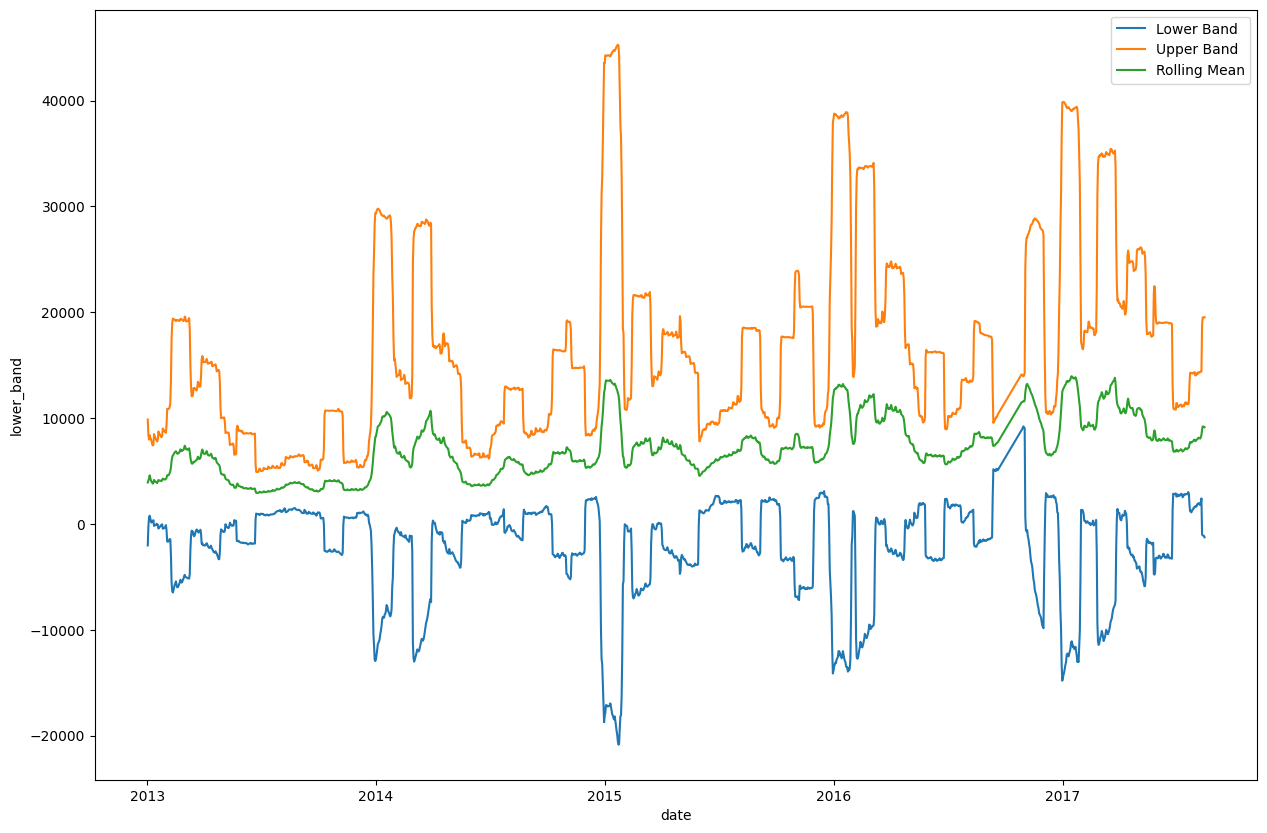

In [44]:
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
sns.lineplot(data["lower_band"], ax=axes, label="Lower Band")
sns.lineplot(data["upper_band"], ax=axes, label="Upper Band")
sns.lineplot(data["rolling_mean"], ax=axes, label="Rolling Mean")
axes.legend()
plt.show()

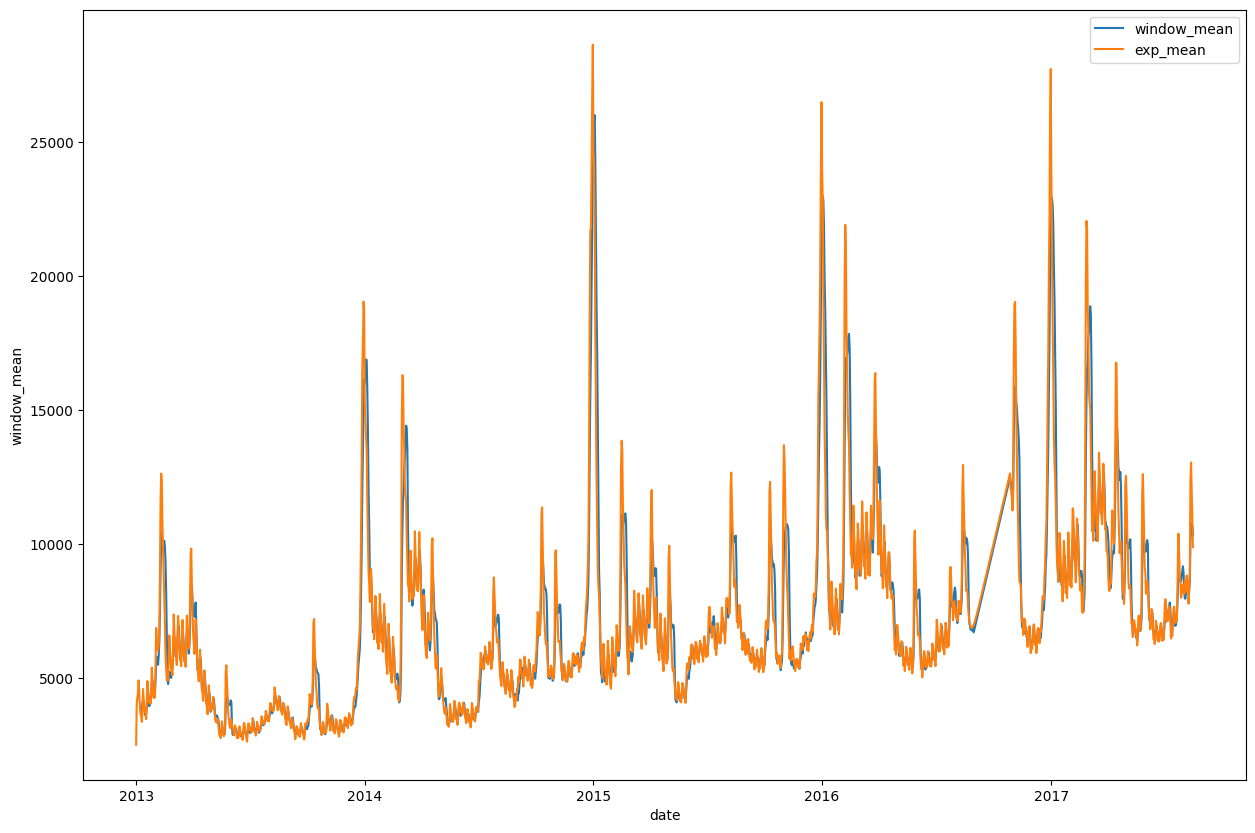

In [45]:
# Реинициализируем датафрейм
data = df_25.copy()

# Постройте оконное среднее с окном в 10 точек.
data["window_mean"] = data["sales"].rolling(window=10).mean()

# Постройте экспоненциально среднее с окном в 7 точек (span=7).
data["exp_mean"] = data["sales"].ewm(span=7).mean()

# Отобразите их на отдельном графике.
fig, axes = plt.subplots(1, 1, figsize=(15, 10))

sns.lineplot(data["window_mean"], ax=axes, label="window_mean")
sns.lineplot(data["exp_mean"], ax=axes, label="exp_mean")
axes.legend()
plt.show()

In [46]:
# Реинициализируем датафрейм
data = df_25.copy()

# Напишите свою скользящую функцию, которая будет являться средним арифметическим
# между максимальным и минимальным значением unit_sales, используя окно 10.

# Через лямбда функцию
data["custom_rolling_mean_lambda"] = (
    data["sales"]
    .rolling(window=10)
    .apply(lambda x: np.mean(np.array([np.max(x), np.min(x)])))
)


# Через обычную
def custom_rolling(array_data):
    return np.mean(np.array([np.max(array_data), np.min(array_data)]))


data["custom_rolling_mean"] = data["sales"].rolling(window=10).apply(custom_rolling)


display(data.head(15))
display(data.tail(15))

,sales,custom_rolling_mean_lambda,custom_rolling_mean
date,,,
2013-01-01,2511.619,NaN,NaN
2013-01-02,5316.224,NaN,NaN
2013-01-03,4442.913,NaN,NaN
2013-01-04,4844.354,NaN,NaN
2013-01-05,5817.526,NaN,NaN
2013-01-06,3201.695,NaN,NaN
2013-01-07,2783.978,NaN,NaN
2013-01-08,2884.284,NaN,NaN
2013-01-09,3565.639,NaN,NaN


,sales,custom_rolling_mean_lambda,custom_rolling_mean
date,,,
2017-08-01,7937.218,9608.7390,9608.7390
2017-08-02,10136.327,8163.0020,8163.0020
2017-08-03,6873.802,8163.0020,8163.0020
2017-08-04,9276.890,8163.0020,8163.0020
2017-08-05,9910.015,8163.0020,8163.0020
2017-08-06,8064.109,8505.0645,8505.0645
2017-08-07,7527.348,8505.0645,8505.0645
2017-08-08,6025.029,8080.6780,8080.6780
2017-08-09,9707.858,8080.6780,8080.6780


In [47]:
# Постройте скользящее среднее с окном 50 и экспоненциальное скользящее среднее с окном 10 (span=10). 
# Укажите индексы датафрейма, на которых одно скользящее пересекается с другим. 
# Для этого вычтите из одно скользящего среднего другое, возьмите знак этой разности (np.sign), 
# продифференциируйте его (diff()) и оставьте только те точки, где результат дифференциирования не равен нулю.

# Реинициализируем датафрейм
data = df_25.copy()

data['rolling_mean'] = data['sales'].rolling(window=50, min_periods=1).mean()
data['exp_mean'] = data['sales'].ewm(span=10).mean()

# Вычисляем пересечения
crossings = np.sign(data['rolling_mean'] - data['exp_mean']).diff()
crossings = crossings[crossings != 0]

# Выводим индексы датафрейма, на которых одно скользящее пересекается с другим
print(crossings.index)

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-07', '2013-01-12',
               '2013-01-14', '2013-01-18', '2013-02-20', '2013-02-22',
               '2013-02-26', '2013-03-02',
               ...
               '2017-04-19', '2017-04-29', '2017-05-02', '2017-05-26',
               '2017-05-30', '2017-06-03', '2017-06-05', '2017-07-02',
               '2017-07-04', '2017-07-15'],
              dtype='datetime64[ns]', name='date', length=136, freq=None)


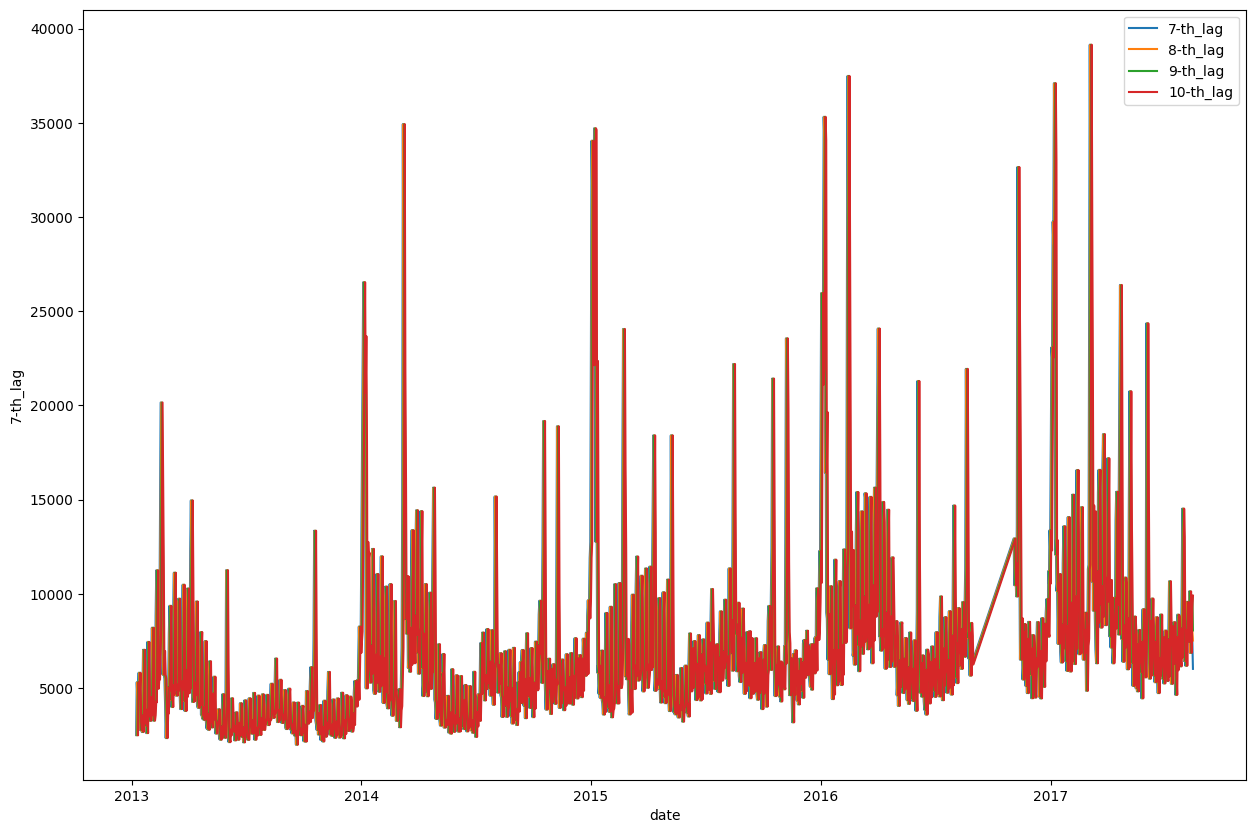

In [48]:
# Получите лаговые факторы с 7-го по 10-й предыдущих дня (лаг7, лаг8, лаг9, лаг10) и отобразите на графике.

# Реинициализируем датафрейм
data = df_25.copy()

data["7-th_lag"] = data["sales"].shift(periods=7)
data["8-th_lag"] = data["sales"].shift(periods=8)
data["9-th_lag"] = data["sales"].shift(periods=9)
data["10-th_lag"] = data["sales"].shift(periods=10)

fig, axes = plt.subplots(1, 1, figsize=(15, 10))
sns.lineplot(data["7-th_lag"], ax=axes, label = "7-th_lag")
sns.lineplot(data["8-th_lag"], ax=axes, label = "8-th_lag")
sns.lineplot(data["9-th_lag"], ax=axes, label = "9-th_lag")
sns.lineplot(data["10-th_lag"], ax=axes, label = "10-th_lag")

axes.legend()
plt.show()

---

### Ответы для модуля 10

In [67]:
# Выберите продукт с номером 103501 (item_nbr) и приведите данные
# к виду временного ряда с группировкой по дате и агрегацией .sum()['unit_sales'].
data = pd.DataFrame(df.query("item_nbr == 103501")["sales"])
data = data.groupby(by=data.index).sum()
data.head()

,sales
date,
2013-01-02,185.0
2013-01-03,153.0
2013-01-04,155.0
2013-01-05,160.0
2013-01-06,173.0


In [75]:
# Проведите тест Адфуллера. Стационарен ли ряд?
adfuller_test(data, "sales")

adf:  -4.154403058014598
p-value:  0.0007863083913836962
Critical values:  {'1%': -3.4344462031760283, '5%': -2.8633492329988335, '10%': -2.5677331999518147}
ряд стационарен


In [ ]:
# Постройте прогноз методом скользящего среднего с окном 6, как в ноутбуке выше. 
# Посчитайте метрики MSE, MAE, MAPE.
